# Estimating a variable term truth using a variable term model
### This notebook allows one to fix the following:
* Number of terms used in defining the truth, labeled nTruth
* Number of terms used in the model trying to estimate the truth, labeled nModel
* Number of moments used in each term (either 1 or 2), labeled nMoment
* The true parameters for the nTruth model
* Lower and upper bound for parameters

Spence Lunderman,
Lunderman@math.arizona.edu,
Sept. 21, 2018

In [1]:
import numpy as np
import emcee
import matplotlib.pyplot as plt
import pandas as pd
import corner
import time

plt.rcParams['figure.figsize'] = [16,8]
plt.rcParams['figure.dpi'] = 80
plt.rcParams['savefig.dpi'] = 100

plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['figure.titlesize'] = 'large'

## All variables for experiment

In [2]:
# Define the number of terms in the truth
nTruth = 2

# Define the number of terms in the model trying to estimate the truth
nModel = 2

# Define the number of moments in each model term, either 1 or 2
nMoment = 1

# True parameters for model with nTruth terms
### The format must be:  [ a_1, a_2, ... , a_nTruth, b_1, b_2, ..., b_nTruth]
### with b_1 > b_2 >  ... > b_nTruth

param_Truth = [ 5.0,    1.5,   0.75,  -0.75]

# Define lower and upper bounds for parameters.
### We are assuming the bounds are the same for all a's and for all b's

param_lb = [-10.,-10.] #[ a's , b's]
param_ub = [ 10., 10.] #[ a's , b's]

# Define where the true model and approximate model will be evaluate
model_eval = [0.1 , 1., 10] # [ lb, ub, nEval]

# Observation error for likelihood distribution
obs_var = 0.1

# Create figures
Plot_figs = True

## Define the nTruth term truth 
$$\begin{align}
nMoments = 1 \quad \Rightarrow\quad &P = \sum_{k=1}^{nTruth}a_k M^{b_k}\\
nMoments = 2 \quad \Rightarrow\quad &P = \sum_{k=1}^{nTruth}a_k M_0^{b_k}M_3^{1-b_k}
\end{align}$$

In [3]:
# Create DataFrame for true parameters
df_params = pd.DataFrame(columns = ['label','lb','ub','true'])
df_params['label'] = ['$a_%s$'%(kk+1) for kk in range(nTruth)] +  ['$b_%s$'%(kk+1) for kk in range(nTruth)]
df_params['lb'] = [param_lb[0] for kk in range(nTruth)] +  [param_lb[0]for kk in range(nTruth)]
df_params['ub'] = [param_ub[0] for kk in range(nTruth)] +  [param_ub[0]for kk in range(nTruth)]
df_params['true'] = param_Truth

## Define the nModel term model

In [4]:
def one_moment_model(a,b,M0):
    return(a*M0**(b))
def two_moment_model(a,b,M0,M3):
    return(a*M0**(b)*M3**(1-b))

def True_model(theta):
    if nMoment == 1:
        M0 = np.linspace(model_eval[0],model_eval[1],model_eval[2])
        P_val = [one_moment_model(theta[kk],theta[kk+nTruth],M0) for kk in range(nTruth)]
        return(np.sum(np.array(P_val),axis=0))
    if nMoment == 2:
        M0 = np.linspace(model_eval[0],model_eval[1],model_eval[2])
        M3 = np.linspace(model_eval[0],model_eval[1],model_eval[2])
        M0,M3 = np.meshgrid(M0,M3)
        P_val = [two_moment_model(theta[kk],theta[kk+nTruth],M0,M3) for kk in range(nTruth)]
        return(np.sum(np.array(P_val),axis=0))
        
def MCMC_model(theta):
    if nMoment == 1:
        M0 = np.linspace(model_eval[0],model_eval[1],model_eval[2])
        P_val = [one_moment_model(theta[kk],theta[kk+nModel],M0) for kk in range(nModel)]
        return(np.sum(np.array(P_val),axis=0))
    if nMoment == 2:
        M0 = np.linspace(model_eval[0],model_eval[1],model_eval[2])
        M3 = np.linspace(model_eval[0],model_eval[1],model_eval[2])
        M0,M3 = np.meshgrid(M0,M3)
        P_val = [two_moment_model(theta[kk],theta[kk+nModel],M0,M3) for kk in range(nModel)]
        return(np.sum(np.array(P_val),axis=0))

### Define and plot the true observations

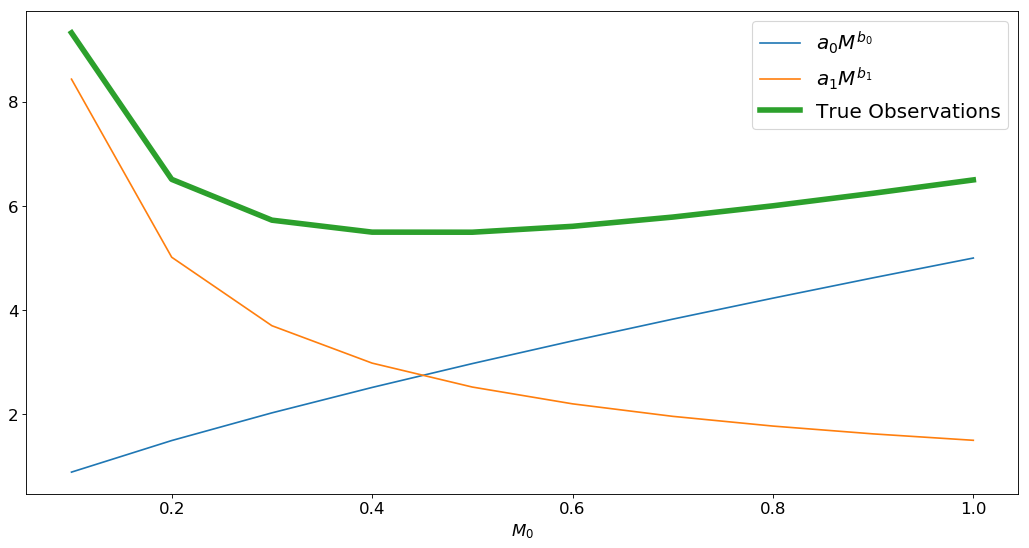

In [5]:
# Calculate the "true" observations
Y_true= True_model(df_params['true'].values)
 
# Plot figs of truth    
if nMoment == 1 and Plot_figs:
    # Plot the first term, second term, and their sum
    M0 = np.linspace(model_eval[0],model_eval[1],model_eval[2])
    for kk in range(nTruth):
        cancel_out = [mm == kk for mm in range(nTruth)]+[1 for mm in range(nTruth)]
        plt.plot(M0,True_model(df_params['true'].values*cancel_out),label='$a_%sM^{b_%s}$'%(kk,kk))
    plt.plot(M0,Y_true,label='True Observations',linewidth=5)
    plt.xlabel('$M_0$')
    plt.legend()
    plt.show()
    
if nMoment == 2 and Plot_figs:
    M0 = np.linspace(model_eval[0],model_eval[1],model_eval[2])
    M3 = np.linspace(model_eval[0],model_eval[1],model_eval[2])
    M0,M3 = np.meshgrid(M0,M3)
    for kk in range(nTruth):
        cancel_out = [mm == kk for mm in range(nTruth)]+[1 for mm in range(nTruth)]
        plt.imshow(True_model(df_params['true'].values*cancel_out)[::-1])
        plt.xticks(np.arange(model_eval[2]),np.linspace(model_eval[0],model_eval[1],model_eval[2]))
        plt.yticks(np.arange(model_eval[2]),np.linspace(model_eval[0],model_eval[1],model_eval[2])[::-1])
        plt.xlabel('$M_0$')
        plt.ylabel('$M_3$')
        plt.colorbar()
        plt.title('Term %s'%(kk+1))
        plt.show()

    plt.imshow(Y_true[::-1])
    plt.xticks(np.arange(model_eval[2]),np.linspace(model_eval[0],model_eval[1],model_eval[2]))
    plt.yticks(np.arange(model_eval[2]),np.linspace(model_eval[0],model_eval[1],model_eval[2])[::-1])
    plt.xlabel('$M_0$')
    plt.ylabel('$M_3$')
    plt.colorbar()
    plt.title('Full %s term model'%(nTruth))
    plt.show()
    
Y_true = np.ravel(Y_true).reshape((model_eval[2]**nMoment),1)
# Define the covariance for the likelihood distribution.
Cov = obs_var*np.identity(model_eval[2]**nMoment)

### Define the posterior distribution for the MCMC Hammer

In [6]:
# Define the log prior. 
# Uniform over the lower bound to upper bound cube with the added condition that b_{k}>b_{k+1}
def lnprior(theta):
    lb_check = [param_lb[0]<theta[kk] for kk in range(nModel)]+[param_lb[1]<theta[kk+nModel] for kk in range(nModel)]
    ub_check = [theta[kk]<param_ub[0] for kk in range(nModel)]+[theta[kk+nModel]<param_ub[1] for kk in range(nModel)]
    b_decending_check = [theta[kk+nModel]>theta[kk+nModel+1] for kk in range(nModel-1)]
    check = lb_check+ub_check+b_decending_check
    if np.all(check)==True:
        return(0.0)
    else:
        return(-np.inf)
    
# Define the log likelihood.
# p( Obs | theta ) ~ Normal with mean = Obs and Cov in the function
def lnlike(theta):
    M_theta = MCMC_model(theta).reshape((len(Y_true),1))
    expo = -0.5*(M_theta-Y_true).T@np.linalg.solve(Cov,(M_theta-Y_true))
    return(expo[0,0])

def lnprob(theta):
    if lnprior(theta)==0.0:
        return(lnlike(theta))
    else:
        return(-np.inf)

### Find initial walkers
* Uniformly sample the prior distribution
* Choose the most likely samples to initialize the hammer

In [7]:
#  Set up for using MCMC Hammer:
ndim , nwalkers = 2*nModel , 4*nModel

post_samps = []
post_val = []
nSamps = int(1E5)

lb = [param_lb[0] for kk in range(nModel)]+[param_lb[1] for kk in range(nModel)]
ub = [param_ub[0] for kk in range(nModel)]+[param_ub[1] for kk in range(nModel)]

for kk in range(nSamps):
    theta = np.random.uniform(lb,ub)
    index = np.argsort(theta[nModel:])+nModel
    theta[nModel:]=theta[index[::-1]]
    post_samps.append(theta)
    post_val.append(lnlike(theta))
    
Index = np.argsort(post_val)[-nwalkers:]
pos = np.array(post_samps)[Index,:]

### Hammer time

In [8]:
# Steps per walker
nSteps = int(5E4)

# Create sampler object
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)
# Run MCMC: (initial walkers, number of MCMC iterations)
sampler.run_mcmc(pos,nSteps)

(array([[ 4.96093632,  1.55145069,  0.65282567, -0.71412746],
        [ 4.98419512,  1.28870253,  0.57239459, -0.76685063],
        [ 3.96162536,  2.82036   ,  1.59728687, -0.51917886],
        [ 5.07612117,  1.47198864,  0.8059707 , -0.77605713],
        [ 3.84402178,  2.75672137,  1.63473519, -0.50899969],
        [ 4.25197266,  2.58233955,  1.1959902 , -0.5380397 ],
        [ 3.79687704,  2.7948173 ,  1.3274728 , -0.51175867],
        [ 3.69173164,  2.91316886,  1.50116804, -0.49076625]]),
 array([-1.23002394, -1.54018388, -1.40141056, -0.44165567, -3.10325609,
        -1.91074407, -0.85743323, -0.95714263]),
 ('MT19937', array([1891733725, 2638317762, 1515168907, 1891014278, 4215083056,
         1619805830, 2858306508, 1995197207,  647708500, 1983056828,
         3435626612, 3775596037, 1236356667,  263046975, 3244052317,
         1692816521,  375365952,  709399316, 2967679085,  867995961,
         2415553804, 3701359226,  767644915, 4022910027, 2877971284,
         2545057667, 343

### Remove burn in samples: burn_in period = 5 $\times$ max IACT

* NOTE: If the true IACT time is too large or the MCMC sampler did not converge to the posterior, then the IACT estimater will fail and through an error.
* If an error is thrown, I dismiss it and set the burn-in period to be 0.

In [9]:
tmp = sampler.chain.reshape((nSteps*nwalkers,ndim))
try:
    IACT = emcee.autocorr.integrated_time(tmp)
    print('IACT: ',IACT)
    Burn_In = int(5* np.max(IACT))
except:
    print('The chain is too short to reliably estimate the autocorrelation time, Burn_In set to zero')
    Burn_In=0
          
tmp = sampler.chain[:,Burn_In:,:]
d1,d2,d3 = tmp.shape
Samples = tmp.reshape(d1*d2,d3)
print('Posterior Mean:',np.mean(Samples,axis=0))

IACT:  [  865.87616431   929.35447612   635.58145918  1340.80264871]
Posterior Mean: [ 4.49109652  2.03712223  1.05936925 -0.67527555]


### Triangle plot of posterior

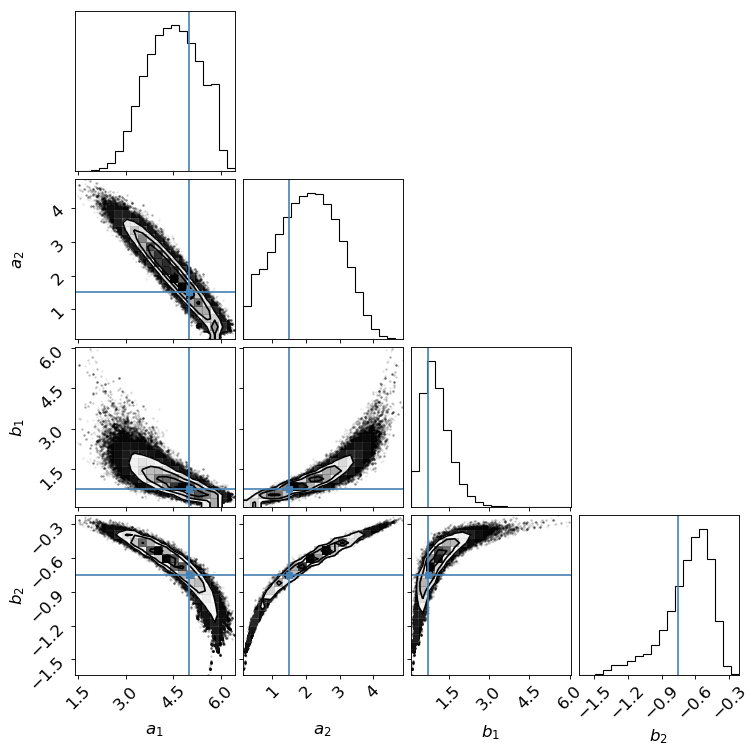

In [10]:
labels = ['$a_%s$'%(kk+1) for kk in range(nModel)] +  ['$b_%s$'%(kk+1) for kk in range(nModel)]
if Plot_figs:
    corner.corner(Samples,labels=labels,truths=param_Truth)
    plt.show()

### Trajectories of posterior samples (blue) plotted against the true observation (orange)
* Note: What is plotted is the column stack of the model outputs and true observations

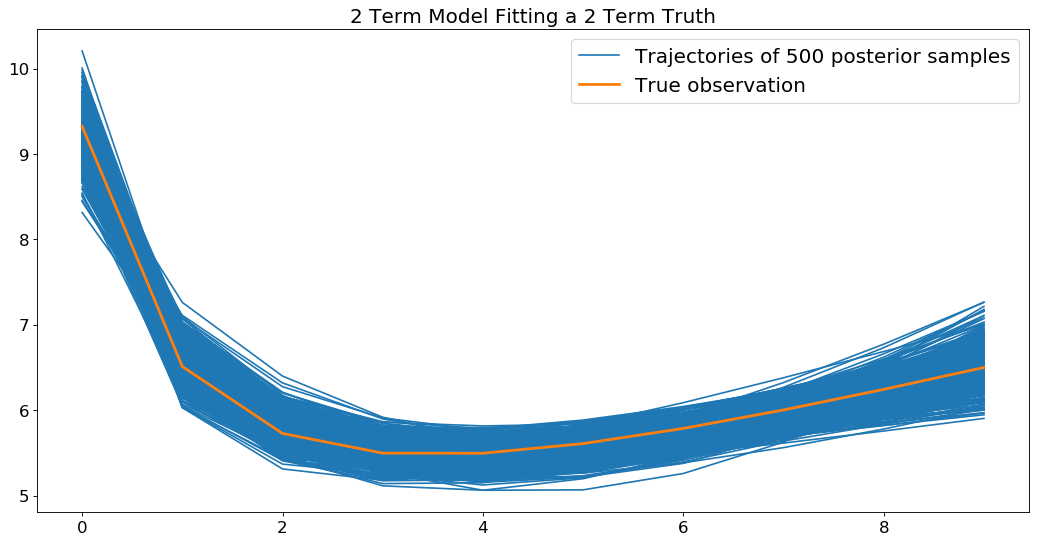

In [11]:
if Plot_figs:
    nSamps = 500
    for kk in range(nSamps):
        theta = Samples[np.random.randint(len(Samples)),:]
        plt.plot(MCMC_model(theta).ravel(),'C0')
    plt.plot(MCMC_model(theta).ravel(),'C0',label='Trajectories of %s posterior samples'%(nSamps))
    plt.plot(Y_true,'C1',label='True observation',linewidth=2.5)
    if nMoment==2:
        plt.xlabel('Column stack of model outputs / observations')
    plt.title('%s Term Model Fitting a %s Term Truth'%(nModel,nTruth))
    plt.legend()
    plt.show()